In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 16

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [4]:
train_dataset = datasets.ImageFolder(r"C:\\Users\\USER\\OneDrive\\Documents\\capstone2\\fruit_quality_dataset\\train", transform=train_transform)
val_dataset   = datasets.ImageFolder(r"C:\\Users\\USER\\OneDrive\\Documents\\capstone2\\fruit_quality_dataset\\valid", transform=val_transform)
test_dataset  = datasets.ImageFolder(r"C:\\Users\\USER\\OneDrive\\Documents\\capstone2\\fruit_quality_dataset\\test", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes
class_names


['fresh', 'rotten']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07093978..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018821478..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0815775].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13165152..1.0616211].


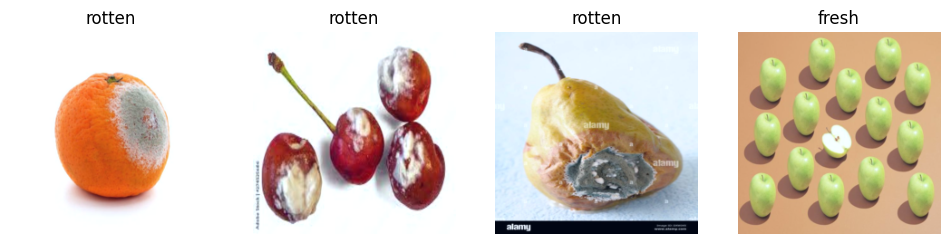

In [5]:
def show_images(loader):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    for i in range(4):
        img = images[i].permute(1, 2, 0)
        img = img * 0.229 + 0.485
        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis("off")

show_images(train_loader)


In [6]:
from torchvision.models import efficientnet_b0

model = efficientnet_b0(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)



c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


In [8]:
train_losses = []
val_accuracies = []


EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Val Acc={val_acc:.4f}")


Epoch 1: Loss=0.6348, Val Acc=0.8125
Epoch 2: Loss=0.4417, Val Acc=0.8542
Epoch 3: Loss=0.3619, Val Acc=0.8333
Epoch 4: Loss=0.3211, Val Acc=0.8750
Epoch 5: Loss=0.3087, Val Acc=0.8750
Epoch 6: Loss=0.2633, Val Acc=0.8958
Epoch 7: Loss=0.2669, Val Acc=0.8958
Epoch 8: Loss=0.2510, Val Acc=0.9167
Epoch 9: Loss=0.2375, Val Acc=0.8958
Epoch 10: Loss=0.1954, Val Acc=0.8958


In [9]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")


Test Accuracy: 0.8333


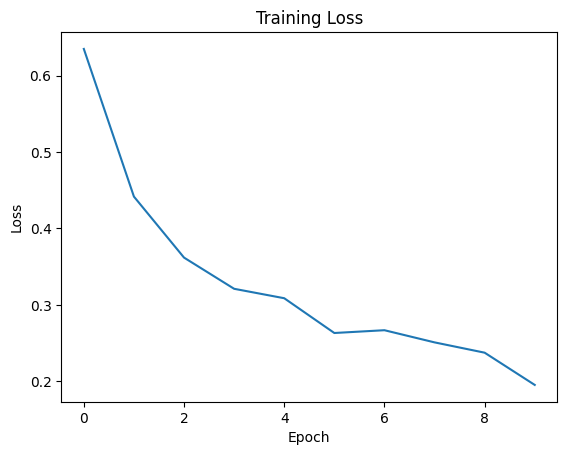

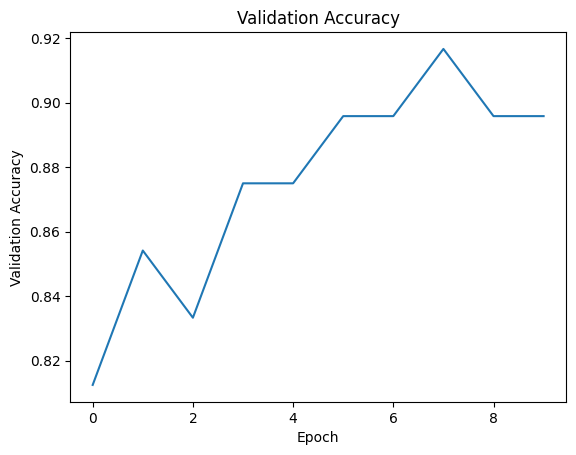

In [10]:
plt.figure()
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

plt.figure()
plt.plot(val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.show()


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np


In [12]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


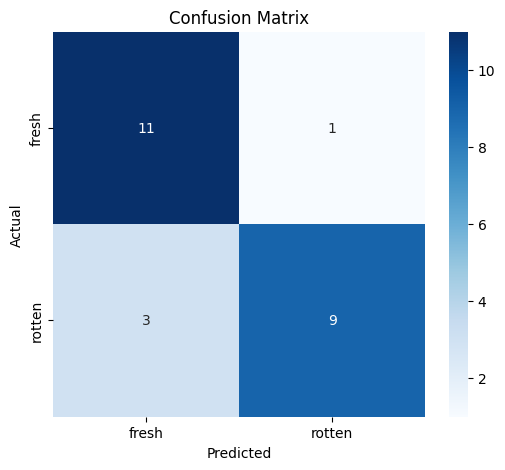

In [13]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [14]:
os.makedirs("models", exist_ok=True)


In [15]:
torch.save({
    "model_state_dict": model.state_dict(),
    "class_names": class_names
}, "models/fruit_quality_model.pth")
